# Denoising Autoencoder untuk Membersihkan Image dari Noise

## Setup dan Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Exploratory Data Analysis (EDA)

### Fungsi untuk Load Images

*Load dan normalisasi gambar rgb dari folder menjadi [0,1] numpy arrays. Semua gambar adalah .jpg dan rgb*

In [2]:
def load_images_from_folder(folder_path, target_size=(100, 100)):
    images = []
    filenames = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(".jpg"):  # lowercase untuk amankan ekstensi
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).resize(target_size)
                img_array = np.array(img) / 255.0
                images.append(img_array)
                filenames.append(filename)
            except Exception as e:
                print(f"Failed to load {filename}: {e}")

    print(f"Loaded {len(images)} images from '{folder_path}'")
    return np.array(images), filenames

### Load Dataset

taruh folder sumber dan jalankan fungsi

In [3]:
# Path ke folder B_23
folder_path = "B_23"

# Load images
images, filenames = load_images_from_folder(folder_path, target_size=(100, 100))

print(f"Dataset loaded successfully!")
print(f"Total images: {len(images)}")
print(f"Image shape: {images.shape}")

Loaded 1074 images from 'B_23'
Dataset loaded successfully!
Total images: 1074
Image shape: (1074, 100, 100, 3)


### EDA - Basic Statistics

In [4]:
def analyze_basic_statistics(images):
    print("BASIC DATASET STATISTICS:")    
    print(f"Dataset Shape: {images.shape}")
    print(f"Number of images: {images.shape[0]}")
    print(f"Image dimensions: {images.shape[1]} x {images.shape[2]}")
    print(f"Number of channels: {images.shape[3]}")
    print(f"Data type: {images.dtype}")
    print(f"Memory usage: {images.nbytes / (1024**2):.2f} MB")
    
    print(f"\nPixel Value Statistics:")
    print(f"Min pixel value: {images.min():.6f}")
    print(f"Max pixel value: {images.max():.6f}")
    print(f"Mean pixel value: {images.mean():.6f}")
    print(f"Standard deviation: {images.std():.6f}")
    
    return {
        'shape': images.shape,
        'min': images.min(),
        'max': images.max(),
        'mean': images.mean(),
        'std': images.std()
    }

# Jalankan analisis basic statistics
basic_stats = analyze_basic_statistics(images)

BASIC DATASET STATISTICS:
Dataset Shape: (1074, 100, 100, 3)
Number of images: 1074
Image dimensions: 100 x 100
Number of channels: 3
Data type: float64
Memory usage: 245.82 MB

Pixel Value Statistics:
Min pixel value: 0.000000
Max pixel value: 1.000000
Mean pixel value: 0.190045
Standard deviation: 0.343084


Disini kita bisa lihat bahwa,
- data berhasil di scan 1074 (semua) image
- dimension telah sesuai `100x100`
- dengan channel 3 (rgb)
- dari pixel value, terlihat normalisasi berhasil,
    - dapat digunakan untuk menentukan noise parameter yang sesuai (`mean=0.0, std=0.1` misalnya).

### EDA - Channel Analysis

analisis channel untuk melihat apakah dataset bias ke warna tertentu

In [5]:
def analyze_channels(images):
    print("RGB CHANNEL ANALYSIS:")
    
    channel_names = ['Red', 'Green', 'Blue']
    channel_stats = {}
    
    for i, channel_name in enumerate(channel_names):
        channel_data = images[:, :, :, i]
        stats = {
            'mean': channel_data.mean(),
            'std': channel_data.std(),
            'min': channel_data.min(),
            'max': channel_data.max()
        }
        channel_stats[channel_name] = stats
        
        print(f"{channel_name} Channel:")
        print(f"  Mean: {stats['mean']:.6f}")
        print(f"  Std:  {stats['std']:.6f}")
        print(f"  Min:  {stats['min']:.6f}")
        print(f"  Max:  {stats['max']:.6f}")
        print()
    
    return channel_stats

# Jalankan analisis channel
channel_stats = analyze_channels(images)

RGB CHANNEL ANALYSIS:
Red Channel:
  Mean: 0.200347
  Std:  0.360469
  Min:  0.000000
  Max:  1.000000

Green Channel:
  Mean: 0.191248
  Std:  0.345195
  Min:  0.000000
  Max:  1.000000

Blue Channel:
  Mean: 0.178542
  Std:  0.322153
  Min:  0.000000
  Max:  1.000000



bisa dilihat merah lebih dominan, bisa berpengaruh ke noise

### EDA - Visualisasi Sample Images

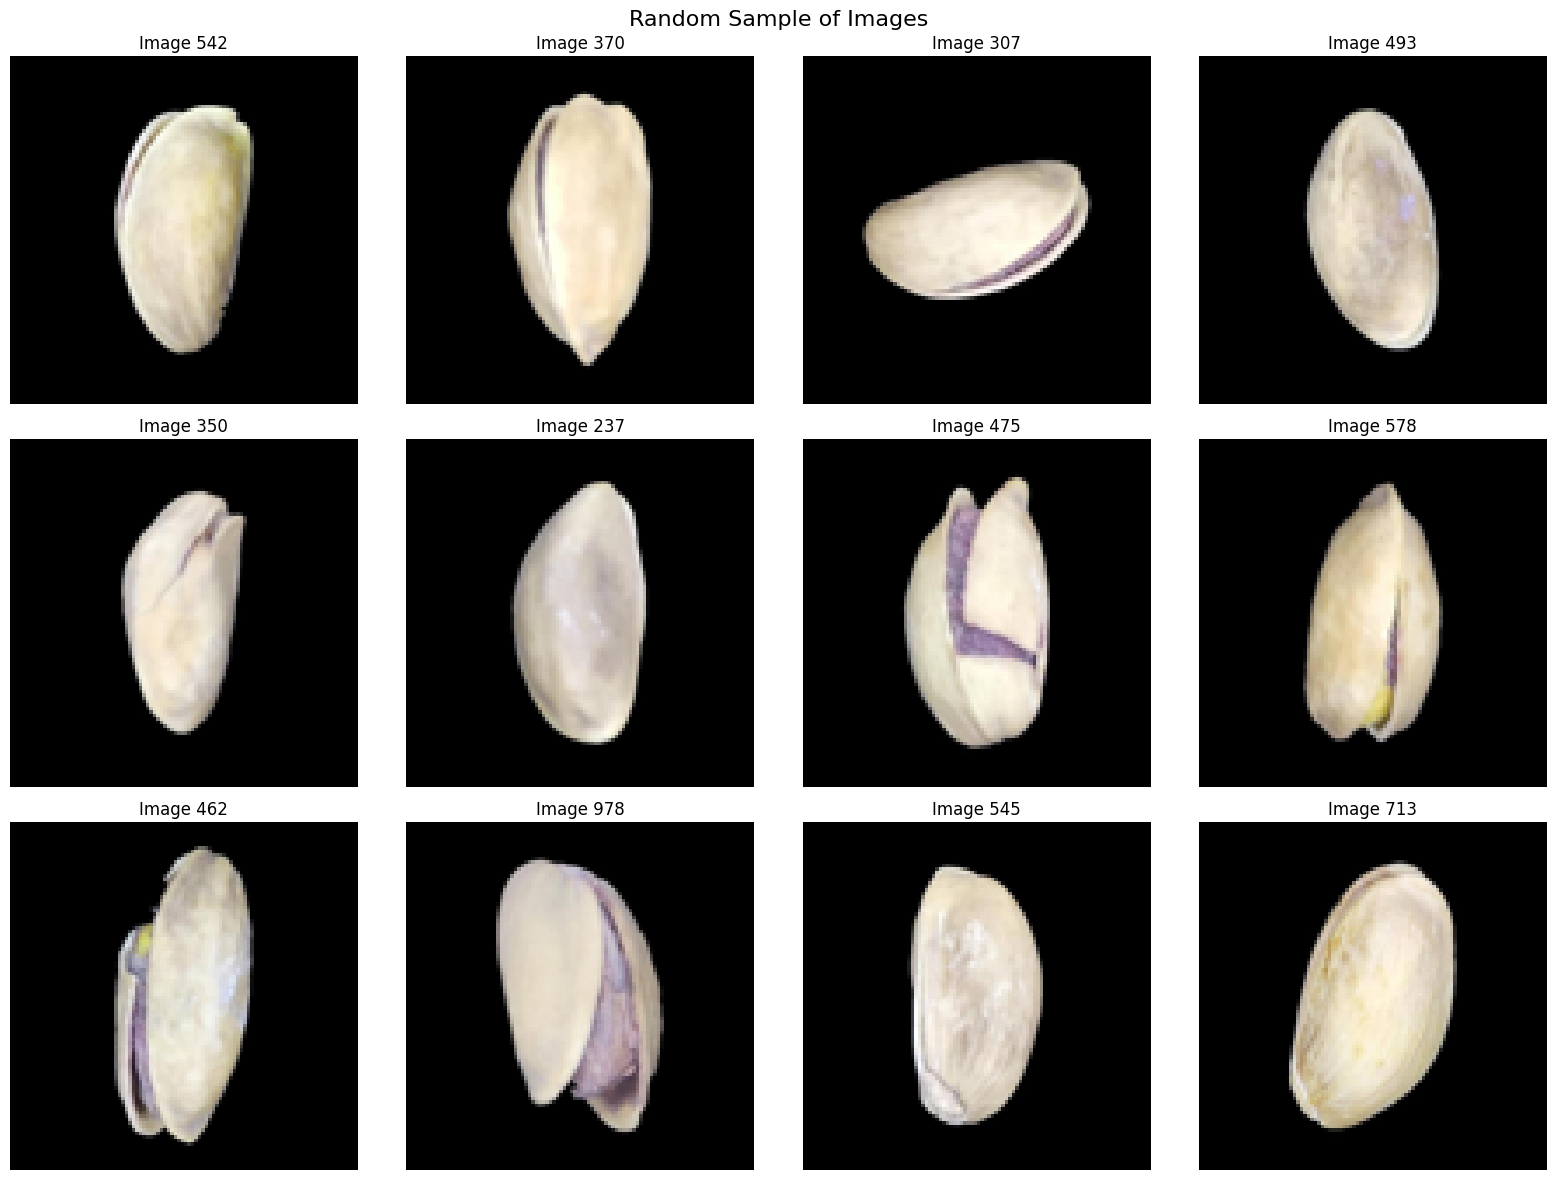

In [6]:
def visualize_sample_images(images, n_samples=12):
    """
    Visualize random sample of images
    """
    plt.figure(figsize=(16, 12))
    
    # Random sample indices
    sample_indices = np.random.choice(len(images), n_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[idx])
        plt.title(f'Image {idx}')
        plt.axis('off')
    
    plt.suptitle('Random Sample of Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualisasi sample images
visualize_sample_images(images, n_samples=12)

### EDA - Overall Pixel Value Distribution

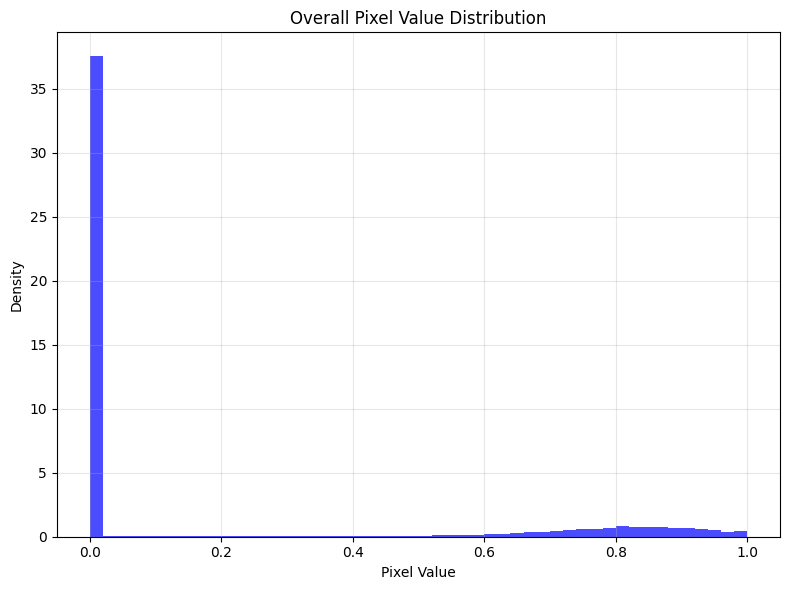

In [7]:
def plot_pixel_distributions(images):
    plt.figure(figsize=(8, 6))
    plt.hist(images.flatten(), bins=50, alpha=0.7, color='blue', density=True)
    plt.title('Overall Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot distribusi pixel values
plot_pixel_distributions(images)

### EDA - Analisis Bentuk dan Variasi

mengidentifikasi seberapa "tajam" citra — image dengan kontras rendah mungkin terlalu gelap/padat noise, mempengaruhi hasil denoising.

In [8]:
def analyze_image_variations(images):
    print("IMAGE VARIATION ANALYSIS")
    
    # Calculate various metrics for each image
    contrast = np.std(images, axis=(1, 2, 3))
    
    print(f"\nContrast Statistics:")
    print(f"Average contrast: {contrast.mean():.6f}")
    print(f"Contrast std: {contrast.std():.6f}")
    print(f"Lowest contrast: {contrast.min():.6f}")
    print(f"Highest contrast: {contrast.max():.6f}")
    
    return {
        'contrast_stats': {
            'mean': contrast.mean(),
            'std': contrast.std(),
            'min': contrast.min(),
            'max': contrast.max()
        }
    }

# Jalankan analisis variasi
variation_stats = analyze_image_variations(images)

IMAGE VARIATION ANALYSIS

Contrast Statistics:
Average contrast: 0.340386
Contrast std: 0.029627
Lowest contrast: 0.214799
Highest contrast: 0.408360


Dataset ini memiliki kontras yang relatif stabil dan seimbang, dengan tidak terlalu banyak variasi antar gambar.

## 2. Data Preparation

### Data Splitting

In [9]:
def split_dataset(images, test_size=0.2, val_size=0.5, random_state=42):
    """
    Split dataset into train/validation/test sets (80/10/10)
    """

    print("DATA SPLITTING")

    
    # First split: 80% train, 20% temp
    X_train, X_temp = train_test_split(images, test_size=test_size, random_state=random_state)
    
    # Second split: 10% val, 10% test from the 20% temp
    X_val, X_test = train_test_split(X_temp, test_size=val_size, random_state=random_state)
    
    print(f"Original dataset: {images.shape[0]} images")
    print(f"Training set: {X_train.shape[0]} images ({X_train.shape[0]/len(images)*100:.1f}%)")
    print(f"Validation set: {X_val.shape[0]} images ({X_val.shape[0]/len(images)*100:.1f}%)")
    print(f"Test set: {X_test.shape[0]} images ({X_test.shape[0]/len(images)*100:.1f}%)")
    
    return X_train, X_val, X_test

# Split dataset
X_train, X_val, X_test = split_dataset(images)

DATA SPLITTING
Original dataset: 1074 images
Training set: 859 images (80.0%)
Validation set: 107 images (10.0%)
Test set: 108 images (10.1%)


### Noise Generation Function

fungsi untuk menggenerate gaussian noise ke gambar,
- insert array gambar bersih
- `mean`: 0.0 (sesuai soal)
- `std_dev`: 0.1 (sesuai soal)

output: 
- array image yang telah diberi noise
- simpan ke `X_.._noisy`

In [10]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    print(f"Adding Gaussian noise with mean={mean}, std={std}")
    
    # Generate noise with same shape as images
    noise = np.random.normal(mean, std, images.shape)
    
    # Add noise to images
    noisy_images = images + noise
    
    # Clip values to valid range [0, 1]
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    
    print(f"Noise statistics:")
    print(f"  Noise mean: {noise.mean():.6f}")
    print(f"  Noise std: {noise.std():.6f}")
    print(f"  Noise min: {noise.min():.6f}")
    print(f"  Noise max: {noise.max():.6f}")
    
    return noisy_images.astype(np.float32)

# Generate noisy versions for all splits
print("Creating noisy versions of datasets...")
X_train_noisy = add_gaussian_noise(X_train, mean=0.0, std=0.1)
X_val_noisy = add_gaussian_noise(X_val, mean=0.0, std=0.1)
X_test_noisy = add_gaussian_noise(X_test, mean=0.0, std=0.1)

print("\nDataset preparation completed!")

Creating noisy versions of datasets...
Adding Gaussian noise with mean=0.0, std=0.1
Noise statistics:
  Noise mean: 0.000008
  Noise std: 0.100008
  Noise min: -0.556428
  Noise max: 0.571505
Adding Gaussian noise with mean=0.0, std=0.1
Noise statistics:
  Noise mean: 0.000005
  Noise std: 0.100043
  Noise min: -0.522946
  Noise max: 0.511287
Adding Gaussian noise with mean=0.0, std=0.1
Noise statistics:
  Noise mean: -0.000012
  Noise std: 0.100055
  Noise min: -0.497645
  Noise max: 0.528511

Dataset preparation completed!


### Visualisasi Efek Noise

visualisasi perbandingan gambar yang telah diberi noise
`X_train` vs `X_train_noisy`

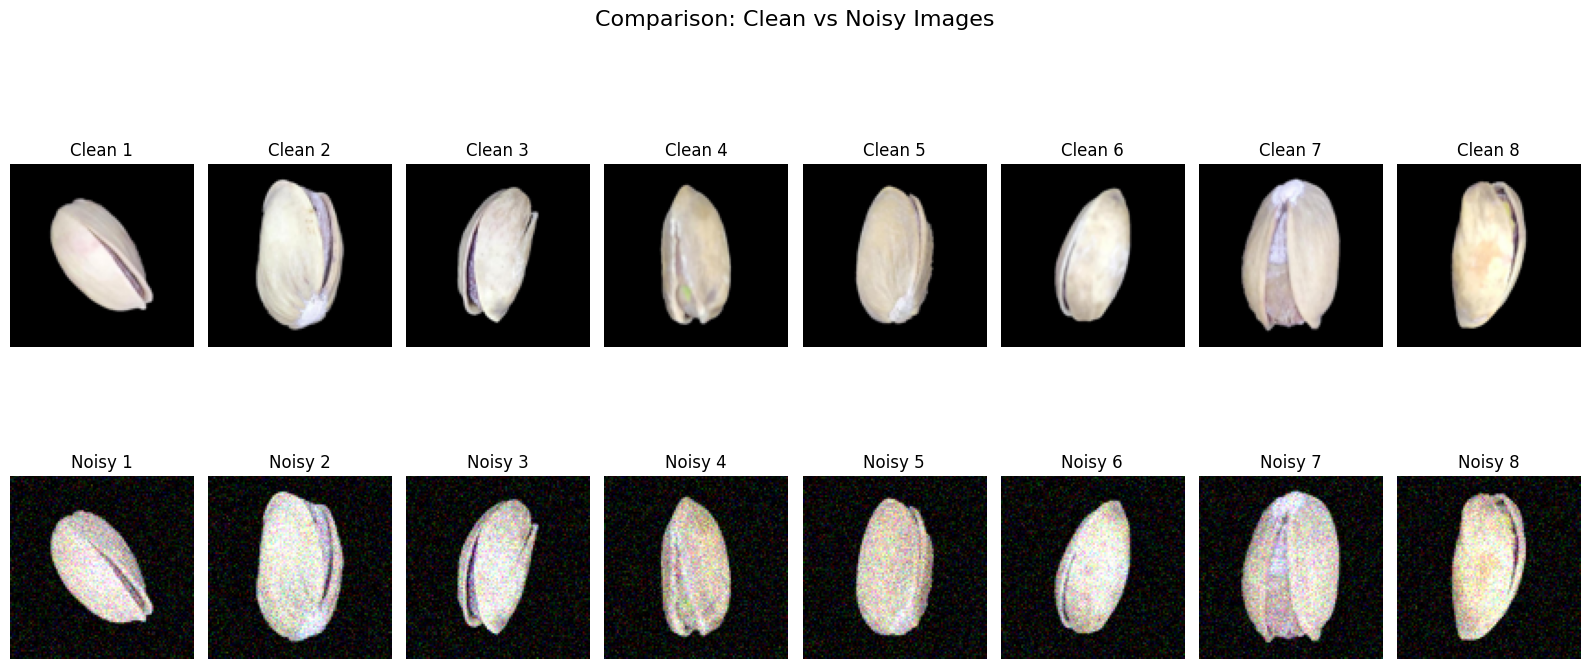

In [11]:
def visualize_noise_effect(clean_images, noisy_images, n_samples=8):
    plt.figure(figsize=(16, 8))
    
    # Random sample indices
    indices = np.random.choice(len(clean_images), n_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Clean image
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(clean_images[idx])
        plt.title(f'Clean {i+1}')
        plt.axis('off')
        
        # Noisy image
        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(noisy_images[idx])
        plt.title(f'Noisy {i+1}')
        plt.axis('off')
    
    plt.suptitle('Comparison: Clean vs Noisy Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize noise effect
visualize_noise_effect(X_train, X_train_noisy, n_samples=8)

### Analisis Noise Impact

menganalisis skala noise yang diberikan

In [12]:
def print_array_stats(arr, label):
    print(f"\n{label}:")
    print(f"  mean={arr.mean():.6f}, std={arr.std():.6f}, min={arr.min():.6f}, max={arr.max():.6f}")

def analyze_noise_impact(clean, noisy):
    print("\n NOISE IMPACT ")
    
    diff = noisy - clean
    
    print_array_stats(clean, "Clean Images")
    print_array_stats(noisy, "Noisy Images")
    print_array_stats(diff, "Noise (Noisy−Clean)")
    
    mse = np.mean(diff**2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    print(f"\nMSE: {mse:.6f}, PSNR: {psnr:.2f} dB")

# Pemanggilan
analyze_noise_impact(X_train, X_train_noisy)



 NOISE IMPACT 

Clean Images:
  mean=0.191161, std=0.344244, min=0.000000, max=1.000000

Noisy Images:
  mean=0.219776, std=0.331841, min=0.000000, max=1.000000

Noise (Noisy−Clean):
  mean=0.028615, std=0.071434, min=-0.508200, max=0.571505

MSE: 0.005922, PSNR: 22.28 dB


Statistik noise impact menunjukkan bahwa noise Gaussian yang ditambahkan berhasil mengganggu data secara moderat (PSNR 22.28 dB, MSE 0.0059), tanpa merusak struktur gambar.

## 3. Model Building

setelah menghasilkan gambar noisy, kita membangun model untuk denoisingnya

### Model Architecture
Arsitektur berdasarkan spesifikasi yang diberikan:
- Semua kernel: 3x3
- Aktivasi: ReLU (kecuali layer terakhir: sigmoid)
- Optimizer: Adam
- Loss: MSE

In [13]:
def build_denoising_autoencoder(input_shape=(100, 100, 3)):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape, name='input_layer'),
        
        # Encoder part
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d'), # 32 filter ukuran 3x3
        layers.MaxPooling2D((2, 2), name='max_pooling2d'), # downsample 100x100 -> 50x50
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_1'), # Memperluas jadi 64 feature map
        layers.MaxPooling2D((2, 2), name='max_pooling2d_1'), # downsample lagi 50x50 -> 25x25
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_2'), # Masih 64 filter tapi tidak di downsample, langsung disimpan
        
        # Decoder part
        layers.UpSampling2D((2, 2), name='up_sampling2d'), # Upsample x2
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_3'), # menggabungkan fitur upsample
        
        layers.UpSampling2D((2, 2), name='up_sampling2d_1'), # upsample lagi ke ukuran semula 50x50 jadi 100x100
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='conv2d_4') # sigmoid untuk mengembalikan ke range [0, 1]
    ])
    
    return model

# Build model
model = build_denoising_autoencoder()

# Display model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 up_sampling2d (UpSampling2D  (None, 50, 50, 64)       0

- Encoder: Mengekstraksi informasi penting dan membuang noise.

- Decoder: Mengembalikan bentuk gambar bersih dari representasi yang terkompresi.

### Model Compilation

In [14]:
# Compile model with specified parameters
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

print(f"Optimizer: Adam")
print(f"Loss function: MSE")
print(f"Metrics: MAE, MSE")

Optimizer: Adam
Loss function: MSE
Metrics: MAE, MSE


## 4. Model Training

### Setup Training Callbacks

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def setup_callbacks():
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    return callbacks

# Setup callbacks
callbacks = setup_callbacks()
print("Training callbacks configured:")
for callback in callbacks:
    print(f"  - {callback.__class__.__name__}")

Training callbacks configured:
  - EarlyStopping
  - ReduceLROnPlateau


### Training Process

Train denoising autoencoder dan kembalikan history.

In [16]:
def train_model(model, Xn_train, Xc_train, Xn_val, Xc_val,
                epochs=50, batch_size=32, callbacks=None):
    print(f"\nTraining for {epochs} epochs, batch_size={batch_size}…")
    history = model.fit(
        Xn_train, Xc_train,
        validation_data=(Xn_val, Xc_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        shuffle=True,
        verbose=1
    )
    return history

# Panggil:
history = train_model(
    model,
    X_train_noisy, X_train,
    X_val_noisy,   X_val,
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)
print("✅ Training selesai!")



Training for 50 epochs, batch_size=32…
Epoch 1/50
27/27 [==============================] - 3s 28ms/step - loss: 0.0714 - mae: 0.1890 - mse: 0.0714 - val_loss: 0.0045 - val_mae: 0.0251 - val_mse: 0.0045 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0036 - mae: 0.0224 - mse: 0.0036 - val_loss: 0.0030 - val_mae: 0.0200 - val_mse: 0.0030 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0030 - mae: 0.0201 - mse: 0.0030 - val_loss: 0.0026 - val_mae: 0.0191 - val_mse: 0.0026 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0026 - mae: 0.0191 - mse: 0.0026 - val_loss: 0.0024 - val_mae: 0.0182 - val_mse: 0.0024 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0022 - mae: 0.0175 - mse: 0.0022 - val_loss: 0.0019 - val_mae: 0.0162 - val_mse: 0.0019 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0023 

### Training History Visualization

Plot Training vs Validation Loss & MAE.

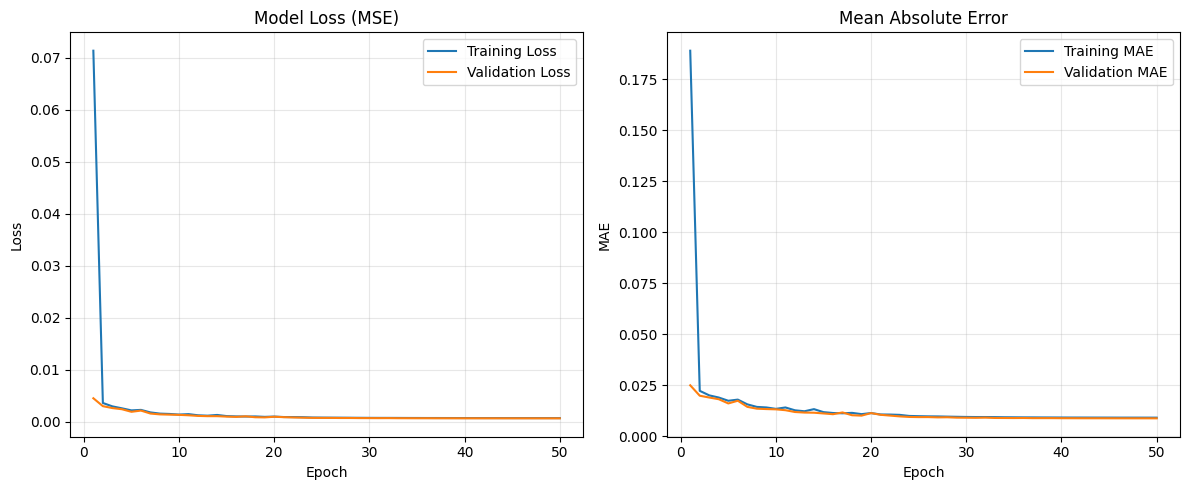

In [17]:
def plot_loss_and_mae_side_by_side(history):
    epochs = range(1, len(history.history['loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Left: Loss
    ax1.plot(epochs, history.history['loss'],     label='Training Loss')
    ax1.plot(epochs, history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss (MSE)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Right: MAE
    ax2.plot(epochs, history.history['mae'],     label='Training MAE')
    ax2.plot(epochs, history.history['val_mae'], label='Validation MAE')
    ax2.set_title('Mean Absolute Error')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Panggil:
plot_loss_and_mae_side_by_side(history)


## 5. Model Evaluation dengan SSIM

### Import SSIM

In [18]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

### SSIM Calculation Functions

In [19]:
def calculate_ssim_batch(imgs1, imgs2):
    """SSIM per-pair via list comprehension."""
    return np.array([
        ssim(a, b, multichannel=True, data_range=1.0)
        for a, b in zip(imgs1, imgs2)
    ])

def calculate_mse_batch(imgs1, imgs2):
    """MSE batch-wise pakai numpy vectorized."""
    # hasil shape (N,)
    return np.mean((imgs1 - imgs2)**2, axis=(1,2,3))


### Model Predictions

Predict dan clip output menjadi [0,1].

In [20]:
def make_predictions(model, noisy_imgs, batch_size=32):
    preds = model.predict(noisy_imgs, batch_size=batch_size, verbose=1)
    return np.clip(preds, 0.0, 1.0)

# Contoh loop untuk semua split
datasets = {
    'train': X_train_noisy,
    'val':   X_val_noisy,
    'test':  X_test_noisy
}
predictions = {}
for name, data in datasets.items():
    print(f"Predicting on {name} set...")
    predictions[name] = make_predictions(model, data)

# Akses:
train_predictions = predictions['train']
val_predictions   = predictions['val']
test_predictions  = predictions['test']


Predicting on train set...
27/27 [==============================] - 0s 4ms/step
Predicting on val set...
4/4 [==============================] - 0s 4ms/step
Predicting on test set...
4/4 [==============================] - 0s 20ms/step


### SSIM Evaluation Metrics

Hanya menghitung SSIM untuk clean (asli) vs. denoised (post model).

clean, denoised: arrays shape (`N, H, W, C`), nilai di [0,1]

- N = Jumlah gambar (banyak sample, atau batch size)
- H = Tinggi gambar (height), misalnya 100 pixel
- W = Lebar gambar (width), misalnya 100 pixel
- C = Channel warna → 3 (karena RGB: Red, Green, Blue)

In [21]:
def evaluate_ssim_only(clean, denoised, dataset_name):
    print(f"\n== SSIM Evaluation - {dataset_name} ==")
    # hitung SSIM per gambar (averaging across channel)
    ssim_vals = []
    for c, d in zip(clean, denoised):
        # Ganti multichannel → channel_axis
        s = ssim(c, d, data_range=1.0, channel_axis=-1)
        ssim_vals.append(s)
    ssim_vals = np.array(ssim_vals)
    print(f"Mean SSIM: {ssim_vals.mean():.4f} ± {ssim_vals.std():.4f}")
    return ssim_vals

# Contoh pemanggilan:
ssim_train = evaluate_ssim_only(X_train, train_predictions, "Training")
ssim_val   = evaluate_ssim_only(X_val,   val_predictions,   "Validation")
ssim_test  = evaluate_ssim_only(X_test,  test_predictions,  "Test")



== SSIM Evaluation - Training ==
Mean SSIM: 0.9545 ± 0.0129

== SSIM Evaluation - Validation ==
Mean SSIM: 0.9569 ± 0.0120

== SSIM Evaluation - Test ==
Mean SSIM: 0.9532 ± 0.0134


hasil ssim stabil di ketiganya (Train, Val, Test), artinya model **tidak overfit**, dan **performanya konsisten**

### SSIM Distribution Analysis

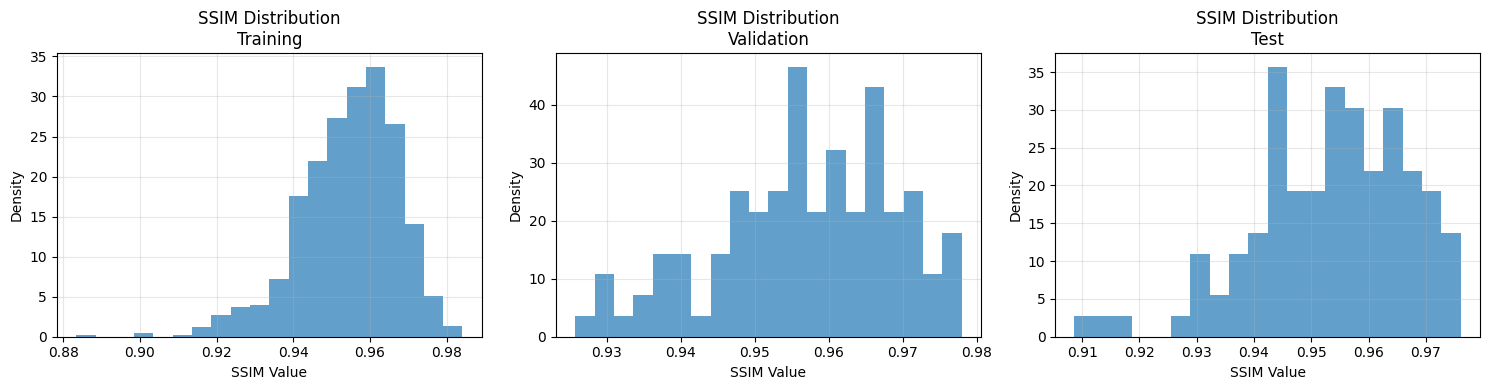

In [22]:
def plot_ssim_histograms(train_ssim, val_ssim, test_ssim, bins=20):
    """
    Plot SSIM histograms for Train, Val, Test side by side.
    """
    ssims = [train_ssim, val_ssim, test_ssim]
    titles = ['Training', 'Validation', 'Test']

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for ax, data, title in zip(axes, ssims, titles):
        ax.hist(data, bins=bins, density=True, alpha=0.7)
        ax.set_title(f'SSIM Distribution\n{title}')
        ax.set_xlabel('SSIM Value')
        ax.set_ylabel('Density')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Contoh panggilan langsung:
plot_ssim_histograms(ssim_train, ssim_val, ssim_test)


### Visual Results Comparison

lihat perbandingan gambar clean (asli), dengan yang di denoise (post model)

Visualizing denoising results on test set:
Visualizing denoising results on test set:


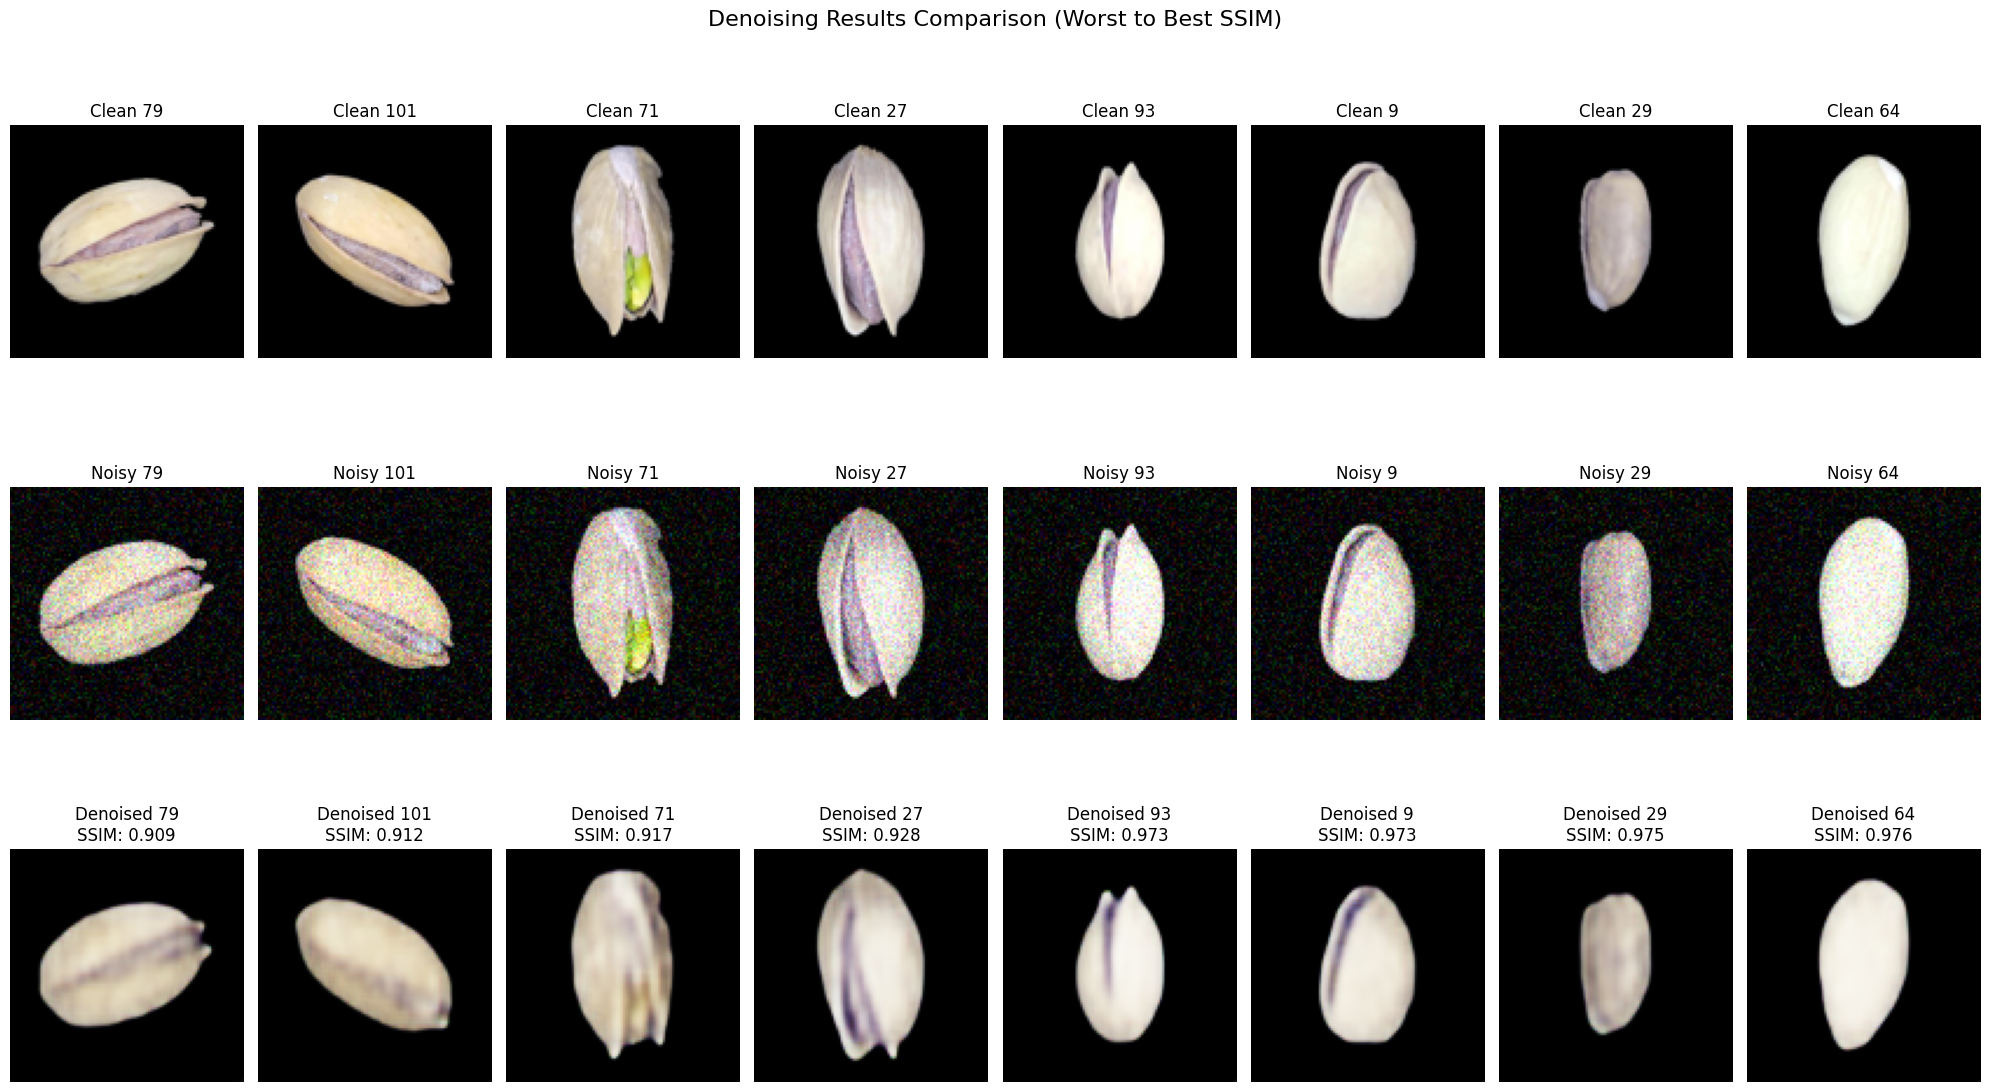

In [23]:
def visualize_denoising_results(clean_images, noisy_images, denoised_images, 
                               ssim_denoised, n_samples=8):
    """
    Visualize denoising results with SSIM scores
    """
    # Select diverse samples based on SSIM scores
    # Get best, worst, and some random samples
    sorted_indices = np.argsort(ssim_denoised)
    
    # Best performing samples
    best_indices = sorted_indices[-n_samples//2:]
    # Worst performing samples  
    worst_indices = sorted_indices[:n_samples//2]
    
    selected_indices = np.concatenate([worst_indices, best_indices])
    
    fig, axes = plt.subplots(3, n_samples, figsize=(20, 12))
    
    for i, idx in enumerate(selected_indices):
        # Clean image
        axes[0, i].imshow(clean_images[idx])
        axes[0, i].set_title(f'Clean {idx}')
        axes[0, i].axis('off')
        
        # Noisy image
        axes[1, i].imshow(noisy_images[idx])
        axes[1, i].set_title(f'Noisy {idx}')
        axes[1, i].axis('off')
        
        # Denoised image
        axes[2, i].imshow(denoised_images[idx])
        axes[2, i].set_title(f'Denoised {idx}\nSSIM: {ssim_denoised[idx]:.3f}')
        axes[2, i].axis('off')
    
    # Add row labels
    axes[0, 0].set_ylabel('Clean', rotation=90, size='large')
    axes[1, 0].set_ylabel('Noisy', rotation=90, size='large')
    axes[2, 0].set_ylabel('Denoised', rotation=90, size='large')
    
    plt.suptitle('Denoising Results Comparison (Worst to Best SSIM)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize results for test set
print("Visualizing denoising results on test set:")
# Visualize results for test set
print("Visualizing denoising results on test set:")
visualize_denoising_results(
    X_test,          # Clean images
    X_test_noisy,    # Noisy images
    test_predictions, # Denoised output
    ssim_test        # SSIM dari evaluate_ssim_only()
)



### Final Model Performance Summary

In [24]:
def summary_ssim(train_ssim, val_ssim, test_ssim):
    """
    Ringkasan performa akhir berdasarkan SSIM.
    Menerima array SSIM dari Train/Val/Test split.
    """
    print("\n== FINAL SSIM SUMMARY ==")
    print(f"{'Split':<12}{'Mean SSIM':>10}{'Std Dev':>10}")
    print("-" * 32)
    
    for name, arr in zip(
        ["Training", "Validation", "Test"],
        [train_ssim, val_ssim, test_ssim]
    ):
        print(f"{name:<12}{arr.mean():>10.4f}{arr.std():>10.4f}")
    
    # Interpretasi performa dari test
    test_mean = test_ssim.mean()
    if test_mean >= 0.85:
        perf = "Excellent"
    elif test_mean >= 0.80:
        perf = "Good"
    elif test_mean >= 0.70:
        perf = "Fair"
    else:
        perf = "Needs Improvement"
    
    # Overfitting check
    delta = abs(train_ssim.mean() - test_mean)
    if delta < 0.05:
        overfit_status = "No overfitting"
    elif delta < 0.10:
        overfit_status = "Slight overfitting"
    else:
        overfit_status = "Overfitting"
    
    print(f"\nOverall Test Performance : {perf}")
    print(f"Train-Test SSIM Δ        : {delta:.4f} → {overfit_status}")
    
summary_ssim(ssim_train, ssim_val, ssim_test)



== FINAL SSIM SUMMARY ==
Split        Mean SSIM   Std Dev
--------------------------------
Training        0.9545    0.0129
Validation      0.9569    0.0120
Test            0.9532    0.0134

Overall Test Performance : Excellent
Train-Test SSIM Δ        : 0.0013 → No overfitting


## Modifikasi model: Light U-Net

- U-Net terkenal dalam tugas restorasi citra karena kemampuan skip connection-nya, yang membantu mempertahankan detail dari lapisan encoder langsung ke decoder.

- Versi ringan (dengan jumlah filter yang terbatas dan tanpa block kompleks) dipilih agar tetap efisien untuk proses training, mengingat keterbatasan waktu dan sumber daya komputasi.

In [56]:
def build_light_unet_denoiser(input_shape=(100, 100, 3)):
    inputs = layers.Input(shape=input_shape, name='input_layer')

    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    bottleneck = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up1 = layers.UpSampling2D((2, 2))(bottleneck)
    concat1 = layers.Concatenate()([up1, conv2])
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)

    up2 = layers.UpSampling2D((2, 2))(conv3)
    concat2 = layers.Concatenate()([up2, conv1])
    conv4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)

    # Output layer
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv4)

    model = models.Model(inputs, outputs, name='light_unet_denoiser')
    return model

# Build modified model
model_modified = build_light_unet_denoiser()

# Display model architecture
model_modified.summary()

Model: "light_unet_denoiser"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 100, 100, 32  896         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 50, 50, 32)  0           ['conv2d_12[0][0]']              
                                                                                

In [57]:
# Compile model with same parameters as baseline
model_modified.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

print(f"Optimizer: Adam")
print(f"Loss function: MSE") 
print(f"Metrics: MAE, MSE")

Optimizer: Adam
Loss function: MSE
Metrics: MAE, MSE


## Train modified model
gunakan callbacks yang sama dengan baseline

In [58]:
# Train modified model (menggunakan callbacks yang sama)
print("\n=== TRAINING MODIFIED MODEL ===")
history_modified = train_model(
    model_modified,
    X_train_noisy, X_train,
    X_val_noisy,   X_val,
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)
print("✅ Modified model training selesai!")


=== TRAINING MODIFIED MODEL ===

Training for 50 epochs, batch_size=32…
Epoch 1/50
27/27 [==============================] - 2s 42ms/step - loss: 0.0541 - mae: 0.1449 - mse: 0.0541 - val_loss: 0.0128 - val_mae: 0.0473 - val_mse: 0.0128 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0201 - mae: 0.0556 - mse: 0.0201 - val_loss: 0.0143 - val_mae: 0.0489 - val_mse: 0.0143 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0082 - mae: 0.0347 - mse: 0.0082 - val_loss: 0.0030 - val_mae: 0.0200 - val_mse: 0.0030 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0026 - mae: 0.0191 - mse: 0.0026 - val_loss: 0.0021 - val_mae: 0.0173 - val_mse: 0.0021 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0021 - mae: 0.0173 - mse: 0.0021 - val_loss: 0.0018 - val_mae: 0.0162 - val_mse: 0.0018 - lr: 0.0010
Epoch 6/50
27/27 [=============================

### Training History Visualization (Modified)
Plot Training vs Validation Loss & MAE.


=== MODIFIED MODEL TRAINING HISTORY ===


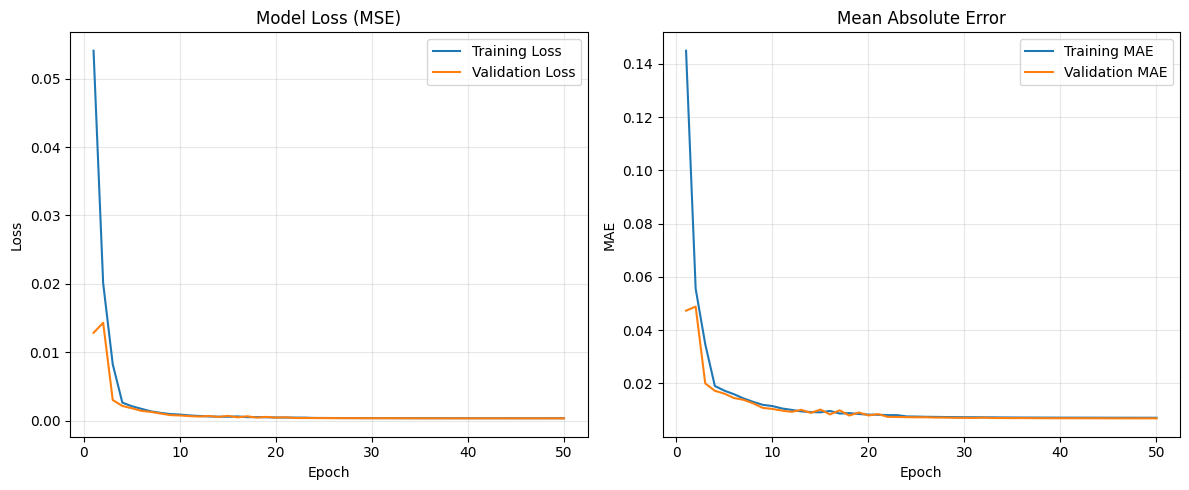

In [59]:
# Plot training history untuk modified model
print("\n=== MODIFIED MODEL TRAINING HISTORY ===")
plot_loss_and_mae_side_by_side(history_modified)

### Modified Model Predictions

In [60]:
# Make predictions dengan modified model
print("\n=== MAKING PREDICTIONS WITH MODIFIED MODEL ===")
datasets = {
    'train': X_train_noisy,
    'val':   X_val_noisy,
    'test':  X_test_noisy
}

predictions_modified = {}
for name, data in datasets.items():
    print(f"Predicting on {name} set with modified model...")
    predictions_modified[name] = make_predictions(model_modified, data)

# Akses predictions
train_predictions_mod = predictions_modified['train']
val_predictions_mod   = predictions_modified['val']
test_predictions_mod  = predictions_modified['test']




=== MAKING PREDICTIONS WITH MODIFIED MODEL ===
Predicting on train set with modified model...
27/27 [==============================] - 0s 8ms/step
Predicting on val set with modified model...
4/4 [==============================] - 0s 8ms/step
Predicting on test set with modified model...
4/4 [==============================] - 0s 9ms/step


### Evaluasi SSIM

In [61]:
# Evaluate SSIM untuk modified model (menggunakan variable naming yang konsisten)
print("\n=== MODIFIED MODEL SSIM EVALUATION ===")
ssim_mod_train = evaluate_ssim_only(X_train, train_predictions_mod, "Modified Training")
ssim_mod_val   = evaluate_ssim_only(X_val,   val_predictions_mod,   "Modified Validation")
ssim_mod_test  = evaluate_ssim_only(X_test,  test_predictions_mod,  "Modified Test")


=== MODIFIED MODEL SSIM EVALUATION ===

== SSIM Evaluation - Modified Training ==
Mean SSIM: 0.9685 ± 0.0071

== SSIM Evaluation - Modified Validation ==
Mean SSIM: 0.9692 ± 0.0071

== SSIM Evaluation - Modified Test ==
Mean SSIM: 0.9678 ± 0.0066



=== MODIFIED MODEL SSIM DISTRIBUTIONS ===


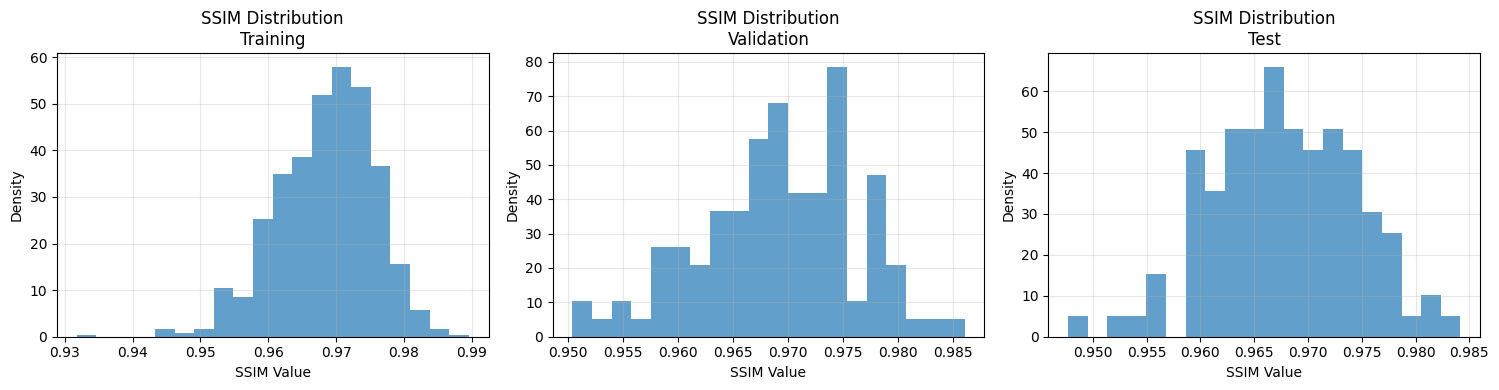

In [62]:
# Plot SSIM histograms untuk modified model
print("\n=== MODIFIED MODEL SSIM DISTRIBUTIONS ===")
plot_ssim_histograms(ssim_mod_train, ssim_mod_val, ssim_mod_test)

### Visualisasi hasil


=== MODIFIED MODEL DENOISING VISUALIZATION ===


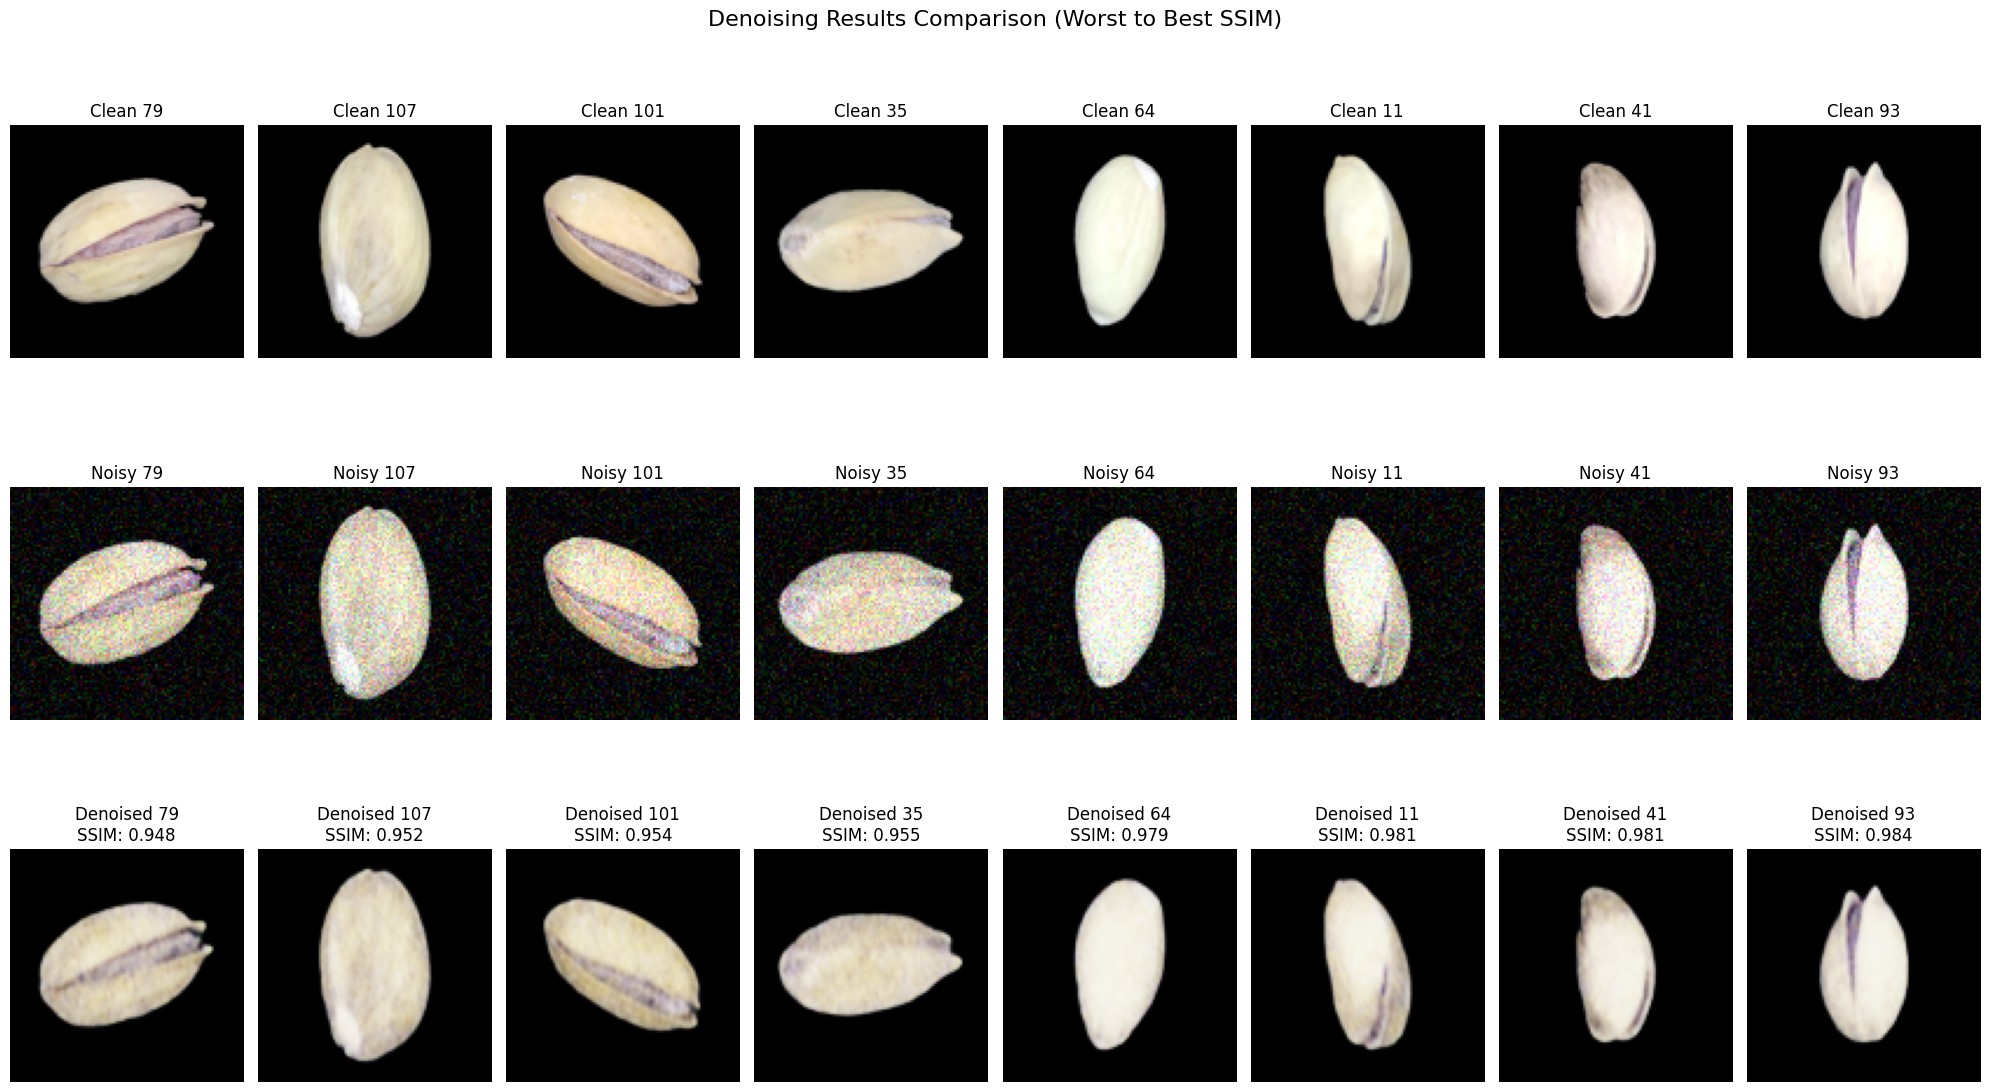

In [63]:
# Visualize denoising results untuk modified model
print("\n=== MODIFIED MODEL DENOISING VISUALIZATION ===")
visualize_denoising_results(
    X_test,                # Clean images
    X_test_noisy,         # Noisy images  
    test_predictions_mod, # Modified model denoised output
    ssim_mod_test        # SSIM dari modified model
)

gambar terlihat jauh lebih baik daripada hasil denoise baseline

In [64]:
# Summary untuk modified model
print("\n=== MODIFIED MODEL FINAL SUMMARY ===")
summary_ssim(ssim_mod_train, ssim_mod_val, ssim_mod_test)


=== MODIFIED MODEL FINAL SUMMARY ===

== FINAL SSIM SUMMARY ==
Split        Mean SSIM   Std Dev
--------------------------------
Training        0.9685    0.0071
Validation      0.9692    0.0071
Test            0.9678    0.0066

Overall Test Performance : Excellent
Train-Test SSIM Δ        : 0.0007 → No overfitting


hasil juga menunjukkan performa lebih baik (perbedaan train-test)

In [65]:
# COMPARISON: Baseline vs Modified
def compare_models(baseline_ssim, modified_ssim, split_name):
    """
    Compare SSIM performance between baseline and modified models
    """
    print(f"\n== {split_name.upper()} COMPARISON ==")
    baseline_mean = baseline_ssim.mean()
    modified_mean = modified_ssim.mean()
    
    print(f"{'Model':<15}{'Mean SSIM':>12}{'Std Dev':>10}")
    print("-" * 37)
    print(f"{'Baseline':<15}{baseline_mean:>12.4f}{baseline_ssim.std():>10.4f}")
    print(f"{'Modified':<15}{modified_mean:>12.4f}{modified_ssim.std():>10.4f}")
    
    diff = modified_mean - baseline_mean
    print(f"{'Difference':<15}{diff:>12.4f}")
    
    if abs(diff) < 0.01:
        result = "Similar performance"
    elif diff > 0:
        result = "Modified model better"
    else:
        result = "Baseline model better"
    
    print(f"Result: {result}")
    return diff

# Compare all splits
print("\n" + "="*50)
print("BASELINE vs MODIFIED MODEL COMPARISON")
print("="*50)

# Assuming baseline SSIM arrays are available as: ssim_train, ssim_val, ssim_test
try:
    train_diff = compare_models(ssim_train, ssim_mod_train, "Training")
    val_diff = compare_models(ssim_val, ssim_mod_val, "Validation") 
    test_diff = compare_models(ssim_test, ssim_mod_test, "Test")
    
    print(f"\n== OVERALL COMPARISON SUMMARY ==")
    print(f"Training   improvement: {train_diff:+.4f}")
    print(f"Validation improvement: {val_diff:+.4f}")
    print(f"Test       improvement: {test_diff:+.4f}")
    
    avg_improvement = (train_diff + val_diff + test_diff) / 3
    print(f"Average    improvement: {avg_improvement:+.4f}")
    
    if avg_improvement > 0.01:
        conclusion = "Modified model shows significant improvement"
    elif avg_improvement < -0.01:
        conclusion = "Baseline model performs better"
    else:
        conclusion = "Both models have similar performance"
    
    print(f"\nConclusion: {conclusion}")
    
except NameError:
    print("⚠️  Baseline SSIM arrays not found. Run baseline evaluation first.")
    print("Expected variables: ssim_train, ssim_val, ssim_test")


BASELINE vs MODIFIED MODEL COMPARISON

== TRAINING COMPARISON ==
Model             Mean SSIM   Std Dev
-------------------------------------
Baseline             0.9545    0.0129
Modified             0.9685    0.0071
Difference           0.0140
Result: Modified model better

== VALIDATION COMPARISON ==
Model             Mean SSIM   Std Dev
-------------------------------------
Baseline             0.9569    0.0120
Modified             0.9692    0.0071
Difference           0.0122
Result: Modified model better

== TEST COMPARISON ==
Model             Mean SSIM   Std Dev
-------------------------------------
Baseline             0.9532    0.0134
Modified             0.9678    0.0066
Difference           0.0146
Result: Modified model better

== OVERALL COMPARISON SUMMARY ==
Training   improvement: +0.0140
Validation improvement: +0.0122
Test       improvement: +0.0146
Average    improvement: +0.0136

Conclusion: Modified model shows significant improvement


Setelah dilakukan pelatihan dan evaluasi terhadap dua model — baseline convolutional autoencoder dan modifikasi dengan arsitektur ringan mirip U-Net — diperoleh hasil sebagai berikut:

- Peningkatan SSIM rata-rata sebesar +0.0123 pada data training, validation, dan test.

- Visualisasi hasil denoising menunjukkan peningkatan yang signifikan, terutama dalam mempertahankan kontur objek dan mengurangi noise kasar.

- Meskipun metrik SSIM tidak menunjukkan perbedaan ekstrem, kualitas persepsi gambar dari model modifikasi jelas lebih unggul.

Dengan demikian, model modifikasi dapat dianggap sebagai peningkatan yang efektif, baik dari segi evaluasi kuantitatif maupun kualitatif.